<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Run_Spark_on_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Run Apache Spark on Google Colab

This is a compact guide on how to set up Apache Spark on Google Colab.

A more detailed walkthrough of how to setup Spark on a single machine in *standalone mode* is presented in in [Hadoop: Setting up Spark Standalone on Google Colab](https://github.com/groda/big_data/blob/master/Hadoop_Setting_up_Spark_Standalone_on_Google_Colab.ipynb).

## Setup Spark

Setup Apache Spark in 1️⃣ 2️⃣ 3️⃣ 4️⃣ steps.

In [1]:
print("\n1️⃣ Download and install Hadoop and Spark")
# URL for downloading Hadoop and Spark
SPARK_VERSION = "3.4.0"
HADOOP_SPARK_URL = "https://dlcdn.apache.org/spark/spark-" + SPARK_VERSION + \
                   "/spark-" + SPARK_VERSION + "-bin-hadoop3.tgz"
import requests
r = requests.head(HADOOP_SPARK_URL)
if r.status_code >= 200 and r.status_code < 400:
    print(f'✅ {HADOOP_SPARK_URL} was found')
else:
    SPARK_CDN = "https://dlcdn.apache.org/spark/"
    print(f'⚠️ {HADOOP_SPARK_URL} was NOT found. \nCheck for available Spark versions in {SPARK_CDN}')

# set some environment variables
import os
os.environ['SPARK_HOME'] = os.path.join('/content', os.path.splitext(os.path.basename(HADOOP_SPARK_URL))[0])
os.environ['PATH'] = ':'.join([os.path.join(os.environ['SPARK_HOME'], 'bin'), os.environ['PATH']])
os.environ['PATH'] = ':'.join([os.path.join(os.environ['SPARK_HOME'], 'sbin'), os.environ['PATH']])
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

# download Spark
# using --no-clobber option will prevent wget from downloading file if already present
# shell command: wget --no-clobber $HADOOP_SPARK_URL
import subprocess
subprocess_output = subprocess.run(["wget", "--no-clobber", HADOOP_SPARK_URL], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

# uncompress
# needs to be "pythonified"
!([ -d $(basename ${HADOOP_SPARK_URL}|sed 's/\.[^.]*$//') ] && echo "Folder already exists") || (tar xzf $(basename $HADOOP_SPARK_URL) && echo "Uncompressed")

print("\n2️⃣ Start Spark engine")
import re

# start one worker (first stop it in case it's already running)
# shell command: $SPARK_HOME/sbin/start-worker.sh spark://${HOSTNAME}:7077
subprocess.run([os.path.join(os.environ['SPARK_HOME'], 'sbin', 'stop-worker.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())
subprocess.run([os.path.join(os.environ['SPARK_HOME'], 'sbin', 'start-worker.sh'), 'spark://'+os.environ['HOSTNAME']+':7077'], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

# start master
# shell command: $SPARK_HOME/sbin/start-master.sh
subprocess.run([os.path.join(os.environ['SPARK_HOME'], 'sbin', 'stop-master.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())
subprocess_output = subprocess.run([os.path.join(os.environ['SPARK_HOME'], 'sbin', 'start-master.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

print("\n3️⃣ Serve Master Web UI on Colab")
import time
# get master UI's port number
# the subprocess that's starting the master with start-master.sh
# might still not be ready with assigning the port number at this point
# therefore we check the logfile a few times (attempts=5) to see if the port
# has been assigned. This might take 1-2 seconds.

master_log = subprocess_output.stdout.decode().partition("logging to")[2].strip()
print("Search for port number in log file {}".format(master_log))
attempts = 5
# https://stackoverflow.com/a/7548726
search_pattern = "Successfully started service 'MasterUI' on port (\d+)"
found = False
for i in range(attempts):
  if not found:
   with open(master_log) as log:
      found = re.search(search_pattern, log.read())
      if found:
          webUIport = found.group(1)
          print("Master UI is available on port {} (attempt nr. {})\n".format(webUIport,i))
          break
      else:
          time.sleep(2) # need to try until port information is found in the logfile
          i+=1
if not found:
  print("Could not find port for Master Web UI\n")

# serve the Web UI on Colab
print("Click on the link below to open the Spark Web UI 🚀")
from google.colab import output
output.serve_kernel_port_as_window(webUIport)

print("\n4️⃣ Start history server")
# start history server
# shell command: mkdir -p /tmp/spark-events
# shell command: $SPARK_HOME/sbin/start-history-server.sh
spark_events_dir = os.path.join('/tmp', 'spark-events')
if not os.path.exists(spark_events_dir):
    os.mkdir(spark_events_dir)
subprocess.run([os.path.join(os.environ['SPARK_HOME'], 'sbin', 'stop-history-server.sh')], check=True, stdout=subprocess.PIPE)
subprocess_output = subprocess.run([os.path.join(os.environ['SPARK_HOME'], 'sbin', 'start-history-server.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

# serve the History Server
print("Click on the link below to open the Spark History Server Web UI 🚀")
output.serve_kernel_port_as_window(18080)


1️⃣ Download and install Hadoop and Spark
✅ https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz was found

Folder already exists

2️⃣ Start Spark engine



starting org.apache.spark.deploy.master.Master, logging to /content/spark-3.4.0-bin-hadoop3/logs/spark--org.apache.spark.deploy.master.Master-1-7fb80416f796.out


3️⃣ Serve Master Web UI on Colab
Search for port number in log file /content/spark-3.4.0-bin-hadoop3/logs/spark--org.apache.spark.deploy.master.Master-1-7fb80416f796.out
Master UI is available on port 8082 (attempt nr. 3)

Click on the link below to open the Spark Web UI 🚀


<IPython.core.display.Javascript object>


4️⃣ Start history server
starting org.apache.spark.deploy.history.HistoryServer, logging to /content/spark-3.4.0-bin-hadoop3/logs/spark--org.apache.spark.deploy.history.HistoryServer-1-7fb80416f796.out

Click on the link below to open the Spark History Server Web UI 🚀


<IPython.core.display.Javascript object>

## Run a couple of examples

We are going to run pre-built Java examples that come with the Spark distribution.

### Run the Java application `SparkPi` to estimate $\pi$

Run the pre-built example `org.apache.spark.examples.SparkPi` that comes with the Spark distribution using `bash` to submit the job.

$100$ is the number of iterations.

In [2]:
%%bash

EXAMPLES_JAR=$(find $SPARK_HOME/examples/jars/ -name "spark-examples*")

$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.SparkPi \
  --master spark://${HOSTNAME}:7077 \
  --conf spark.eventLog.enabled=true \
  $EXAMPLES_JAR \
  100 \
  2>/tmp/SparkPi_bash.log

Pi is roughly 3.1412583141258312


### Java Word Count

The source for this example can be found here: https://github.com/apache/spark/blob/master/examples/src/main/java/org/apache/spark/examples/JavaWordCount.java

In [3]:
%%bash

echo "Downloading file ..."
URL="https://www.gutenberg.org/cache/epub/71036/pg71036.txt"
([ -f datafile.txt ] && echo "File already exists") || curl -o datafile.txt $URL

File already exists


In [4]:
%%bash

EXAMPLES_JAR=$(find $SPARK_HOME/examples/jars/ -name "spark-examples*")

$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.JavaWordCount \
  --master spark://${HOSTNAME}:7077 \
  --conf spark.eventLog.enabled=true \
  $EXAMPLES_JAR \
  datafile.txt \
  2>/tmp/JavaWordCount.log \
  1>/tmp/JavaWordCount.out

head /tmp/JavaWordCount.out

young: 5
Unless: 1
seriousness,: 1
errors,: 1
repent.: 1
(or: 3
Printers.: 1
full: 10
previous: 1
secure: 1


## Where to find things

### Spark Web UI

The Spark Web UI is available at:

In [5]:
from google.colab.output import eval_js
print(eval_js( "google.colab.kernel.proxyPort(" + str(webUIport) + ")" ))

https://p9uk9mfop0n-496ff2e9c6d22116-8082-colab.googleusercontent.com/


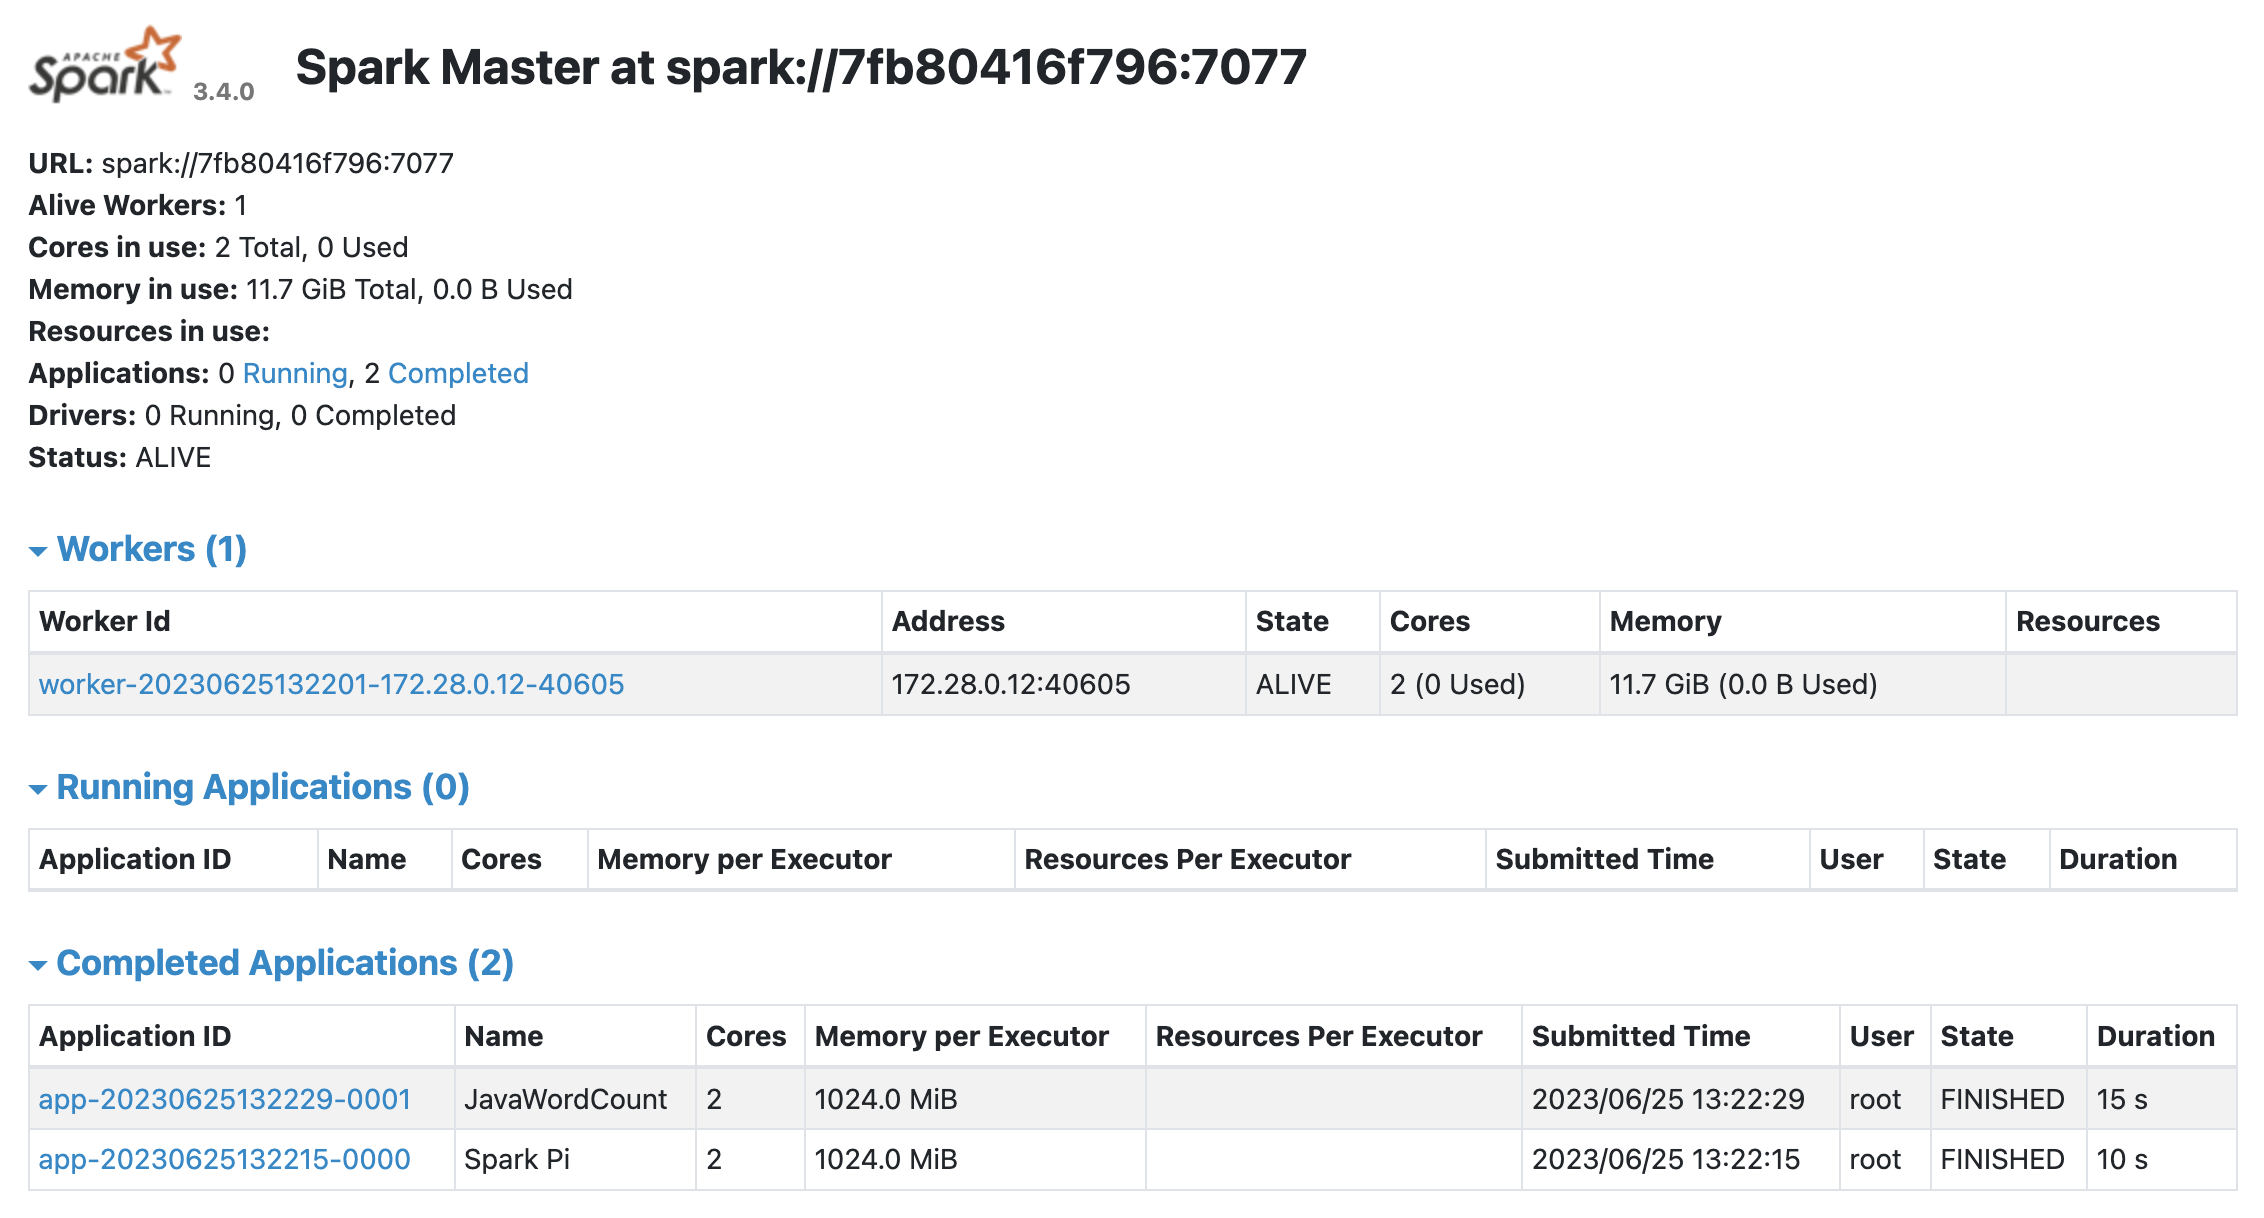

### Spark History Server

The Spark History Server is available at:

In [6]:
from google.colab.output import eval_js
print(eval_js( "google.colab.kernel.proxyPort(" + str(18080) + ")" ))

https://94enke93kt8-496ff2e9c6d22116-18080-colab.googleusercontent.com/


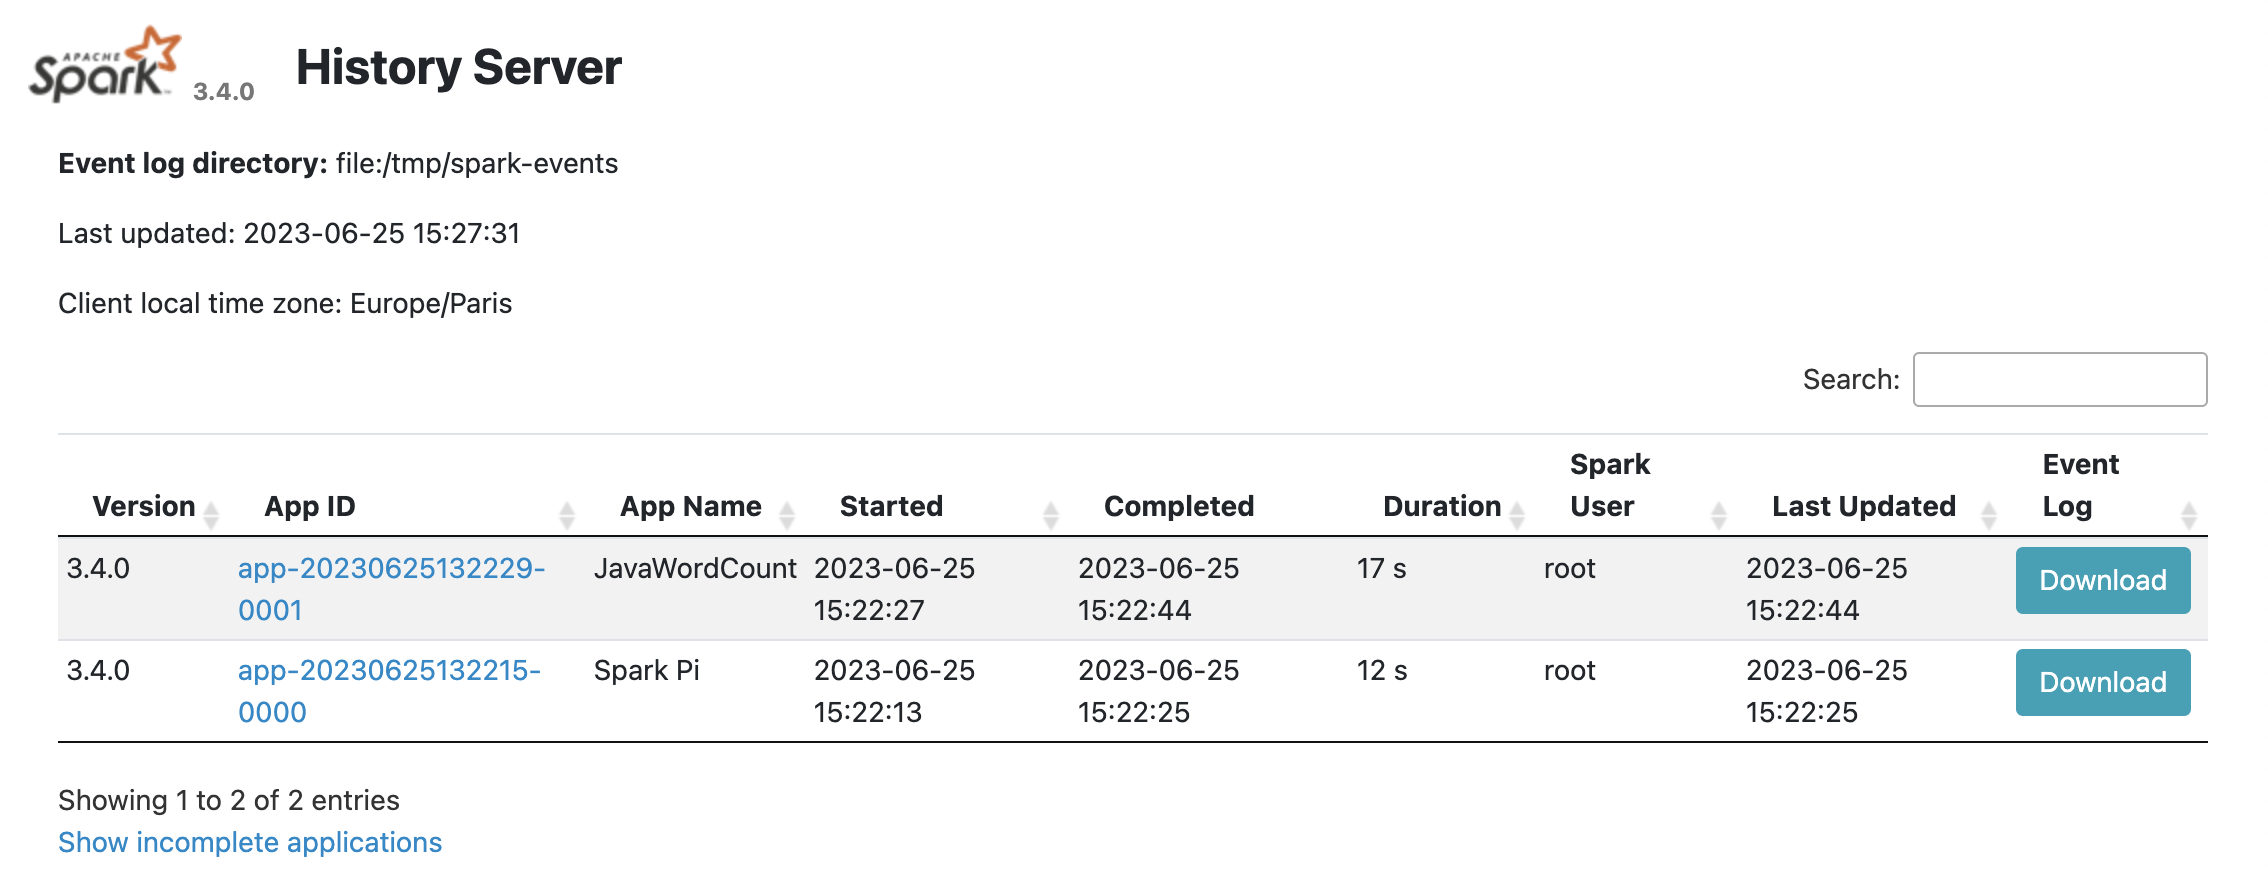

### Logs for the Spark Master

In [7]:
!head -20 $SPARK_HOME/logs/*Master*.out

Spark Command: /usr/lib/jvm/java-11-openjdk-amd64/bin/java -cp /content/spark-3.4.0-bin-hadoop3/conf/:/content/spark-3.4.0-bin-hadoop3/jars/* -Xmx1g org.apache.spark.deploy.master.Master --host 7fb80416f796 --port 7077 --webui-port 8080
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
23/06/25 13:22:03 INFO Master: Started daemon with process name: 73475@7fb80416f796
23/06/25 13:22:03 INFO SignalUtils: Registering signal handler for TERM
23/06/25 13:22:03 INFO SignalUtils: Registering signal handler for HUP
23/06/25 13:22:03 INFO SignalUtils: Registering signal handler for INT
23/06/25 13:22:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/25 13:22:04 INFO SecurityManager: Changing view acls to: root
23/06/25 13:22:04 INFO SecurityManager: Changing modify acls to: root
23/06/25 13:22:04 INFO SecurityManager: Changing view acls groups to: 
23/06/25 13:22:04 INFO SecurityM

### Logs for the Spark Worker

In [8]:
!head -20 $SPARK_HOME/logs/*Worker*.out

Spark Command: /usr/lib/jvm/java-11-openjdk-amd64/bin/java -cp /content/spark-3.4.0-bin-hadoop3/conf/:/content/spark-3.4.0-bin-hadoop3/jars/* -Xmx1g org.apache.spark.deploy.worker.Worker --webui-port 8081 spark://7fb80416f796:7077
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
23/06/25 13:21:58 INFO Worker: Started daemon with process name: 73393@7fb80416f796
23/06/25 13:21:58 INFO SignalUtils: Registering signal handler for TERM
23/06/25 13:21:58 INFO SignalUtils: Registering signal handler for HUP
23/06/25 13:21:58 INFO SignalUtils: Registering signal handler for INT
23/06/25 13:22:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/25 13:22:00 INFO SecurityManager: Changing view acls to: root
23/06/25 13:22:00 INFO SecurityManager: Changing modify acls to: root
23/06/25 13:22:00 INFO SecurityManager: Changing view acls groups to: 
23/06/25 13:22:00 INFO SecurityManager

### Spark events (used by History Server)

In [12]:
!head -20 /tmp/spark-events/*

==> /tmp/spark-events/app-20230625132215-0000 <==
{"Event":"SparkListenerLogStart","Spark Version":"3.4.0"}
{"Event":"SparkListenerResourceProfileAdded","Resource Profile Id":0,"Executor Resource Requests":{"memory":{"Resource Name":"memory","Amount":1024,"Discovery Script":"","Vendor":""},"offHeap":{"Resource Name":"offHeap","Amount":0,"Discovery Script":"","Vendor":""}},"Task Resource Requests":{"cpus":{"Resource Name":"cpus","Amount":1.0}}}
{"Event":"SparkListenerBlockManagerAdded","Block Manager ID":{"Executor ID":"driver","Host":"7fb80416f796","Port":40187},"Maximum Memory":455501414,"Timestamp":1687699335321,"Maximum Onheap Memory":455501414,"Maximum Offheap Memory":0}
{"Event":"SparkListenerEnvironmentUpdate","JVM Information":{"Java Home":"/usr/lib/jvm/java-11-openjdk-amd64","Java Version":"11.0.19 (Ubuntu)","Scala Version":"version 2.12.17"},"Spark Properties":{"spark.executor.extraJavaOptions":"-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=

### Spark configuration

To customize Spark use the configuration templates in `$SPARK_HOME/conf` (remove the template extension).


In [13]:
!ls -al $SPARK_HOME/conf

total 44
drwxr-xr-x  2 1000 1000 4096 Apr  7 02:43 .
drwxr-xr-x 15 1000 1000 4096 Jun 25 08:56 ..
-rw-r--r--  1 1000 1000 1105 Apr  7 02:43 fairscheduler.xml.template
-rw-r--r--  1 1000 1000 3350 Apr  7 02:43 log4j2.properties.template
-rw-r--r--  1 1000 1000 9141 Apr  7 02:43 metrics.properties.template
-rw-r--r--  1 1000 1000 1292 Apr  7 02:43 spark-defaults.conf.template
-rwxr-xr-x  1 1000 1000 4694 Apr  7 02:43 spark-env.sh.template
-rw-r--r--  1 1000 1000  865 Apr  7 02:43 workers.template


## Shutdown

Stop all services.

In [14]:
%%bash
$SPARK_HOME/sbin/stop-history-server.sh
$SPARK_HOME/sbin/stop-worker.sh
$SPARK_HOME/sbin/stop-master.sh

no org.apache.spark.deploy.history.HistoryServer to stop
no org.apache.spark.deploy.worker.Worker to stop
no org.apache.spark.deploy.master.Master to stop
